In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time
from IPython.display import clear_output, display, Image

In [2]:
# ----- Helper Functions -----
def calculate_angle(a, b, c):
    a = np.array(a)  # First point
    b = np.array(b)  # Mid point
    c = np.array(c)  # End point
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    return angle if angle <= 180 else 360 - angle


In [3]:
# ----- Step 0: Open the Video -----
video_path = "one_leg_balance.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
reported_fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Validate FPS
if reported_fps <= 0:
    reported_fps = 30.0
frame_delay = 1.0 / reported_fps

print(f"Video Info: {frame_width}x{frame_height} @ {reported_fps:.2f} FPS")



Video Info: 1920x1080 @ 24.00 FPS


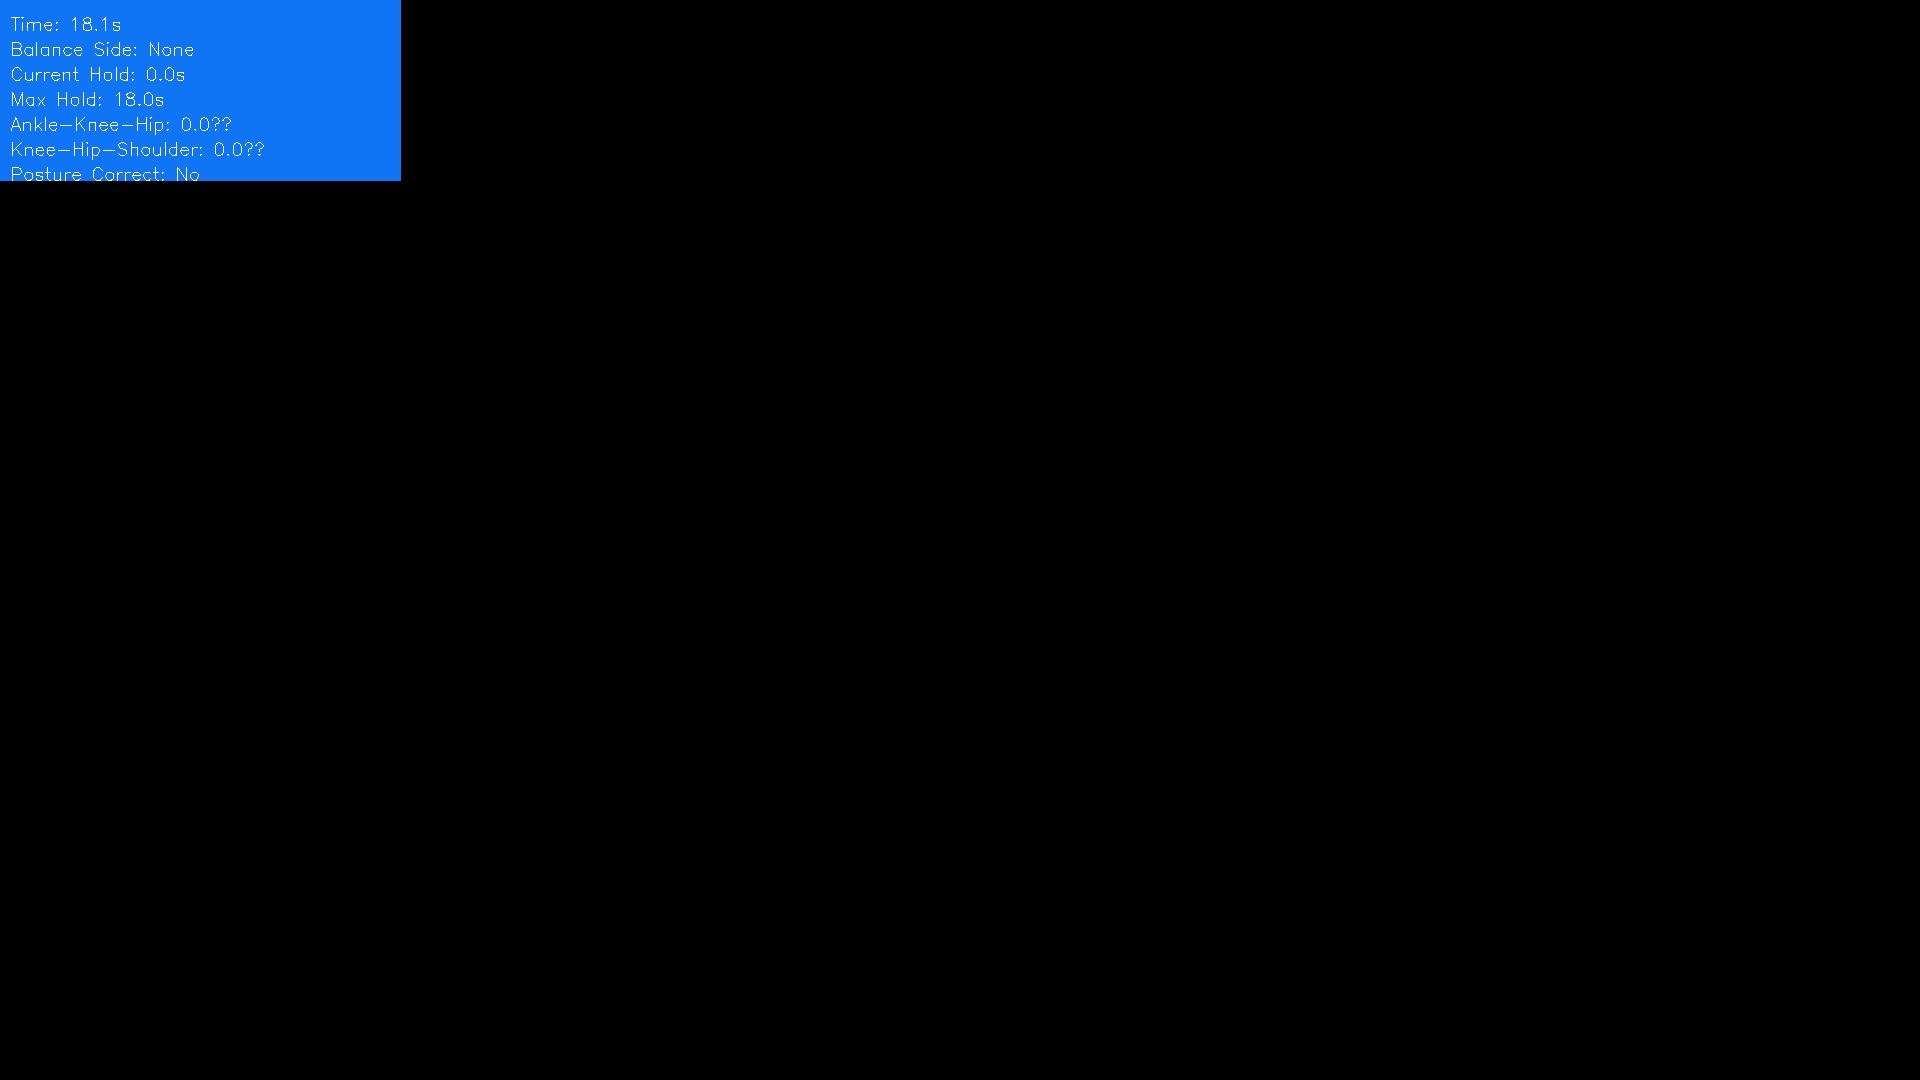

In [4]:
# ----- Step 1: Set Up Pose Detection -----
mp_pose = mp.solutions.pose
mp_draw = mp.solutions.drawing_utils
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Angle thresholds
ANKLE_KNEE_HIP_THRESHOLD = (160, 190)    # For straight leg alignment
KNEE_HIP_SHOULDER_THRESHOLD = (160, 200)  # For upright torso

# Timing variables
hold_start_time = None
current_hold = 0.0
max_hold_duration = 0.0
last_frame_time = time.time()

while cap.isOpened():
    # ----- Frame Timing Control -----
    current_time = time.time()
    elapsed = current_time - last_frame_time
    if elapsed < frame_delay:
        time.sleep(frame_delay - elapsed)
    last_frame_time = time.time()

    # ----- Read Frame -----
    ret, frame = cap.read()
    if not ret:
        break

    # ----- Timestamp Calculation -----
    frame_index = cap.get(cv2.CAP_PROP_POS_FRAMES)
    video_timestamp = frame_index / reported_fps

    # ----- Pose Detection -----
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    
    # ----- Balance Detection Logic -----
    posture_correct = False
    balance_side = "None"
    akh_angle, khs_angle = 0, 0
    
    try:
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            
            # Get ankle positions
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                           landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            
            # Determine standing side
            if left_ankle[1] > right_ankle[1]:  # Lower y = higher position
                balance_side = "Left"
                side = "LEFT"
            else:
                balance_side = "Right"
                side = "RIGHT"
            
            # Get landmarks for standing side
            ankle = [landmarks[getattr(mp_pose.PoseLandmark, f'{side}_ANKLE').value].x,
                     landmarks[getattr(mp_pose.PoseLandmark, f'{side}_ANKLE').value].y]
            knee = [landmarks[getattr(mp_pose.PoseLandmark, f'{side}_KNEE').value].x,
                    landmarks[getattr(mp_pose.PoseLandmark, f'{side}_KNEE').value].y]
            hip = [landmarks[getattr(mp_pose.PoseLandmark, f'{side}_HIP').value].x,
                   landmarks[getattr(mp_pose.PoseLandmark, f'{side}_HIP').value].y]
            shoulder = [landmarks[getattr(mp_pose.PoseLandmark, f'{side}_SHOULDER').value].x,
                        landmarks[getattr(mp_pose.PoseLandmark, f'{side}_SHOULDER').value].y]
            
            # Calculate angles
            akh_angle = calculate_angle(ankle, knee, hip)
            khs_angle = calculate_angle(knee, hip, shoulder)
            
            
            # Check posture correctness
            posture_correct = (
                ANKLE_KNEE_HIP_THRESHOLD[0] <= akh_angle <= ANKLE_KNEE_HIP_THRESHOLD[1] and
                KNEE_HIP_SHOULDER_THRESHOLD[0] <= khs_angle <= KNEE_HIP_SHOULDER_THRESHOLD[1]
            )

    except AttributeError:
        pass

    # ----- Timer Logic -----
    if posture_correct:
        if hold_start_time is None:
            hold_start_time = video_timestamp
        current_hold = video_timestamp - hold_start_time
        max_hold_duration = max(max_hold_duration, current_hold)
    else:
        hold_start_time = None
        current_hold = 0.0

    # ----- Display Information -----
    display_text = [
        f"Time: {video_timestamp:.1f}s",
        f"Balance Side: {balance_side}",
        f"Current Hold: {current_hold:.1f}s",
        f"Max Hold: {max_hold_duration:.1f}s",
        f"Ankle-Knee-Hip: {akh_angle:.1f}°",
        f"Knee-Hip-Shoulder: {khs_angle:.1f}°",
        f"Posture Correct: {'Yes' if posture_correct else 'No'}"
    ]
    # Draw overlay
    y_offset = 30
    cv2.rectangle(image_bgr, (0, 0), (400, 180), (245, 117, 16), -1)
    for i, text in enumerate(display_text):
        cv2.putText(image_bgr, text, (10, y_offset + i*25), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

    # Draw landmarks
    if results.pose_landmarks:
        mp_draw.draw_landmarks(image_bgr, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # ----- Jupyter Display -----
    ret, buffer = cv2.imencode('.jpg', image_bgr)
    if ret:
        clear_output(wait=True)
        display(Image(data=buffer.tobytes()))

          


In [5]:
cap.release()
print(f"Final Max Hold: {max_hold_duration:.1f} seconds")


Final Max Hold: 18.0 seconds
